# Variogram analysis and ordinary kriging for data in 3D (omni-directional)

Interpolate a data set in 3D, using ordinary kriging. Starting from a data set in 3D, the following is done:
- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

# import from package 'geone'
from geone import grf
import geone.covModel as gcm
import geone.img as img
#import geone.imgplot as imgplt
import geone.imgplot3d as imgplt3
#import geone.customcolors as ccol

## Preparation - build a data set in 3D

A data set in 3D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (isotropic) *reference* covariance model in 3D (class `covModel3D` from `geone.covModel`, see jupyter notebook `ex_grf_3d`).

In [2]:
cov_model_ref = gcm.CovModel3D(elem=[
    ('spherical', {'w':9.5, 'r':[15, 15, 15]}), # elementary contribution (same ranges: isotropic)
    ('nugget', {'w':0.5})                       # elementary contribution
    ], alpha=0.0, beta=0.0, gamma=0.0, name='ref model (isotropic)')

In [3]:
cov_model_ref

Covariance model 3D: (Name = ref model (isotropic))
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 9.5,  r = [15, 15, 15]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angles: alpha = 0.0 deg., beta = 0.0 deg., gamma = 0.0 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
         Ox''y''z''-- rotation of angle -gamma around Oy''--> Ox'''y'''z'''

Generate a gaussian random field in 3D (see function `grf3D` from `geone.grf`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

In [4]:
# Simulation grid (domain)
nx, ny, nz = 65, 64, 60     # number of cells
dx, dy, dz = 0.5, 0.5, 0.5  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = grf.grf3D(cov_model_ref, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), nreal=1, printInfo=False) 
    # 4d-array of shape 1 x nz x ny x nx

# Extract n points from the reference simulation
n = 150 # number of data points
ind = np.random.choice(nx*ny*nz, size=n, replace=False) # indexes of extracted grid cells
iz = ind//(nx*ny) # indexes along z-axis
ii = ind%(nx*ny)
iy = ii//nx # indexes along y-axis
ix = ii%nx  # indexes along x-axis
xc = ox + (ix + 0.5)*dx # x-coordinates of data points (centers of the extracted grid cells)
yc = oy + (iy + 0.5)*dy # y-coordinates of data points (centers of the extracted grid cells)
zc = oz + (iz + 0.5)*dz # z-coordinates of data points (centers of the extracted grid cells)
#xc = ox + (ind + np.random.random(n))*dx # x-coordinates of data points (within the extracted grid cells)
#yc = oy + (ind + np.random.random(n))*dy # y-coordinates of data points (within the extracted grid cells)
#zc = oz + (ind + np.random.random(n))*dz # z-coordinates of data points (within the extracted grid cells)

x = np.array((xc, yc, zc)).T # array of coordinates of data points (shape: n x 3)
v = ref[0].reshape(-1)[ind] # value at data points

In [5]:
# Plot covariance model in 3D
#cov_model_ref.plot_model3d_volume()

In [6]:
# Plot covariance model in 3D in an interactive figure
#pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
#cov_model_ref.plot_model3d_volume(plotter=pp)
#pp.show() # show the figure: after closing the pop-up window, the position of the camera is retrieved in output.

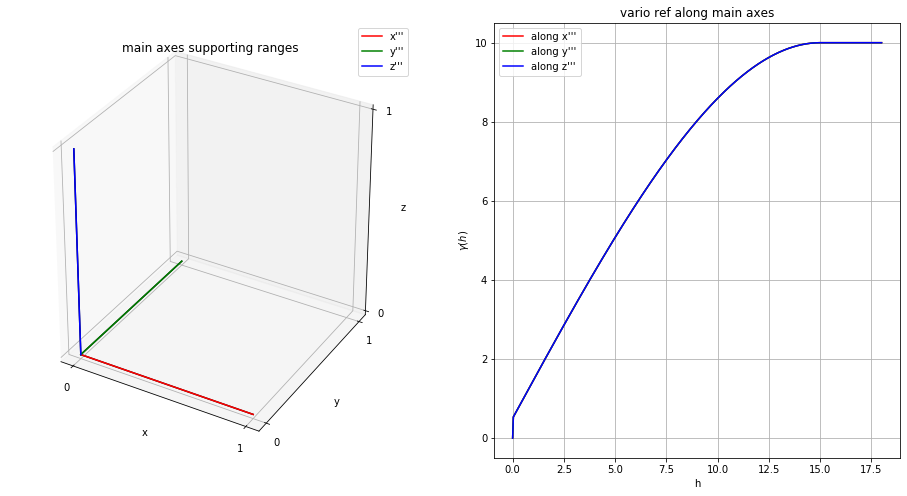

In [7]:
# Plot main axes supporting ranges and vario model curves along each main axis
fig = plt.figure(figsize=(16,8))

# ...plot main axis
fig.add_subplot(1,2,1, projection='3d')
cov_model_ref.plot_mrot(set_3d_subplot=False)
plt.title('main axes supporting ranges')

# ...plot variogram model curves along each main axis
fig.add_subplot(1,2,2)
cov_model_ref.plot_model_curves(vario=True)
plt.title('vario ref along main axes')
plt.show()

In [8]:
# Preparation for plotting reference simulation and data points

# fill image (Img class from geone.img) for view
im_ref = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=1, val=ref)

# data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_ref.vmin()[0] # min value in ref
cmax = im_ref.vmax()[0] # max value in ref
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

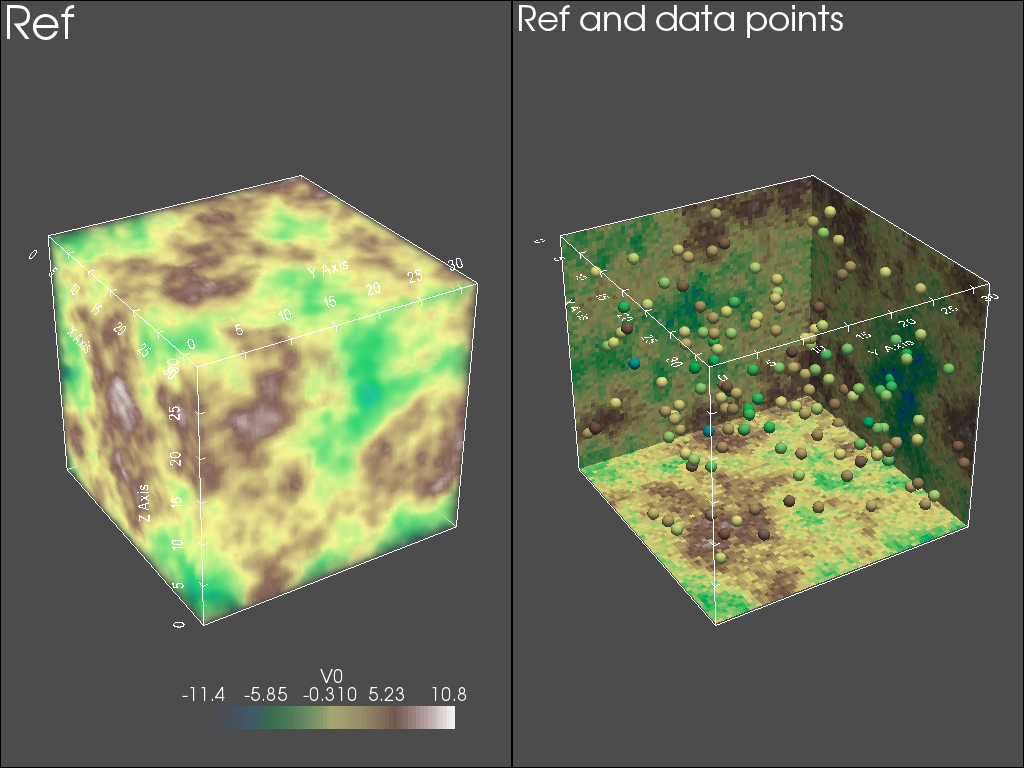

In [9]:
# Plot reference simulation and data points
pp = pv.Plotter(shape=(1,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ref') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+0.5*dx,
                          slice_normal_y=oy+(ny-0.5)*dy,
                          slice_normal_z=oz+0.5*dz,
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Ref and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [10]:
# Plot reference simulation and data points in an interactive figure
pp = pv.Plotter(shape=(1,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ref') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+0.5*dx,
                          slice_normal_y=oy+(ny-0.5)*dy,
                          slice_normal_z=oz+0.5*dz,
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Ref and data points') # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(46.656185040313005, -120.1298122599365, 83.10513889345896),
 (16.25, 16.0, 15.0),
 (-0.02410036860441537, 0.4429844294825158, 0.8962053154658154)]

## Start from a data set in 3D
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

Visualise the data set and the histogram of values.

In [11]:
# Set data_points
data_points = pv.PolyData(x)
data_points['data value'] = v

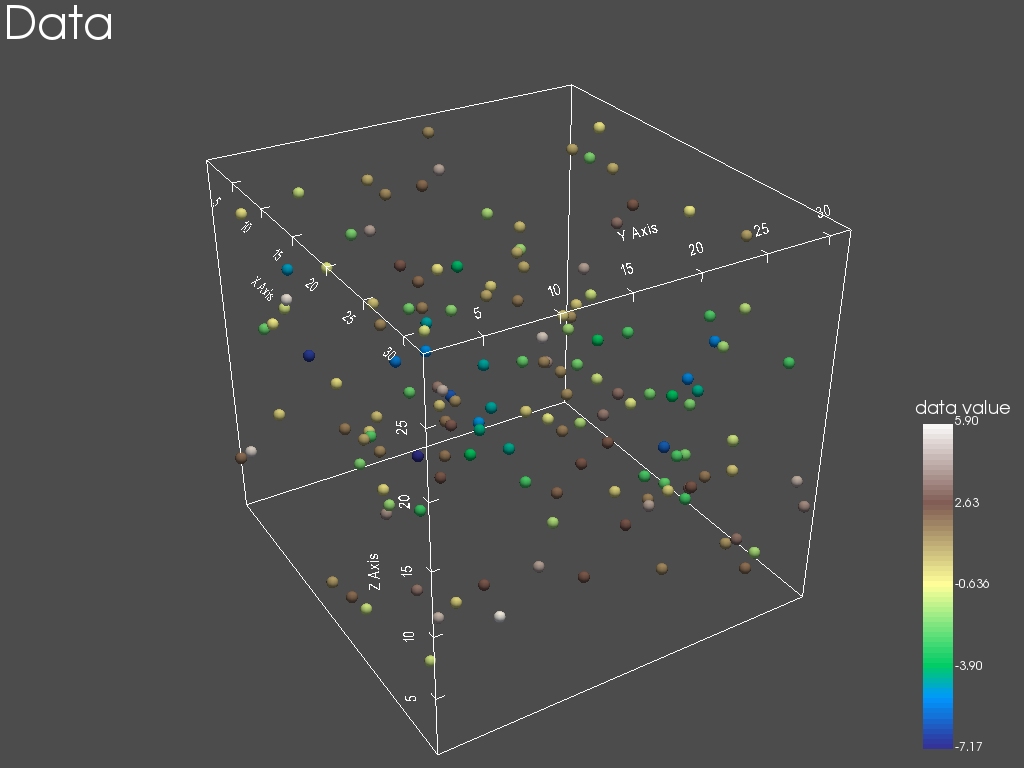

In [12]:
# Plot data points in 3D
pp = pv.Plotter()
pp.add_mesh(data_points, cmap='terrain', point_size=12., render_points_as_spheres=True, 
            scalar_bar_args={'vertical':True, 'title_font_size':18})
pp.add_mesh(data_points.outline())
pp.show_bounds()
pp.add_text('Data')
pp.show(cpos=(165, -100, 115))

In [13]:
# Plot data points in 3D in an interactive figure
pp = pv.Plotter(notebook=False)
pp.add_mesh(data_points, cmap=cmap, point_size=12., render_points_as_spheres=True, 
            scalar_bar_args={'vertical':True, 'title_font_size':18})
pp.add_mesh(data_points.outline())
pp.show_bounds()
pp.add_text('Data')
pp.show()

[(75.52668880197425, 75.77668880197425, 74.27668880197425),
 (16.25, 16.5, 15.0),
 (0.0, 0.0, 1.0)]

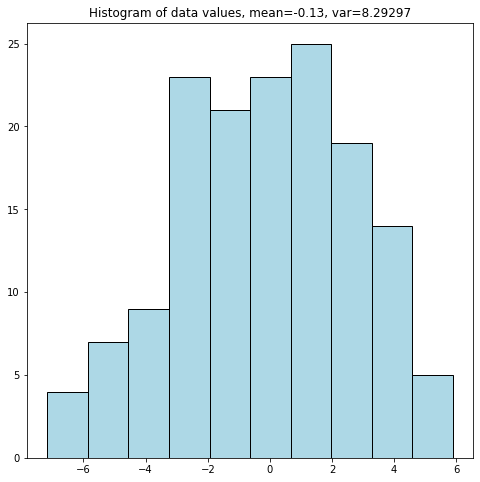

In [14]:
plt.figure(figsize=(8,8))
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

In the following steps, one assumes that the bi-point statistics is omni-directional (same in any direction), then omni-directional analysis is done.

### Omni-directional  variogram cloud
The function `variogramCloud1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

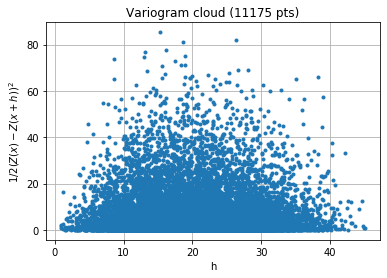

In [15]:
h, g, npair = gcm.variogramCloud1D(x, v)
plt.show()

### Omni-directional experimental variogram
The function `variogramExp1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

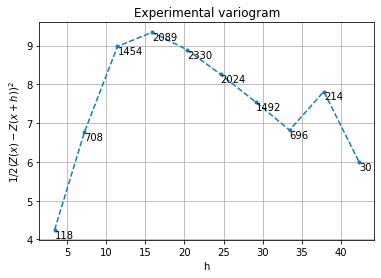

In [16]:
hexp, gexp, cexp = gcm.variogramExp1D(x, v)
# hexp, gexp, cexp = gcm.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 
plt.show()

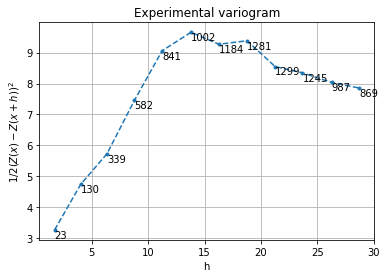

In [17]:
hexp, gexp, cexp = gcm.variogramExp1D(x, v, hmax=30, ncla=12)
plt.show()

### Omni-directional model fitting
The function `covModel1D_fit` is used to fit a covariance model in 1D (class `covModel1D`) (see jupyter notebook `ex_vario_analysis_data1D`).

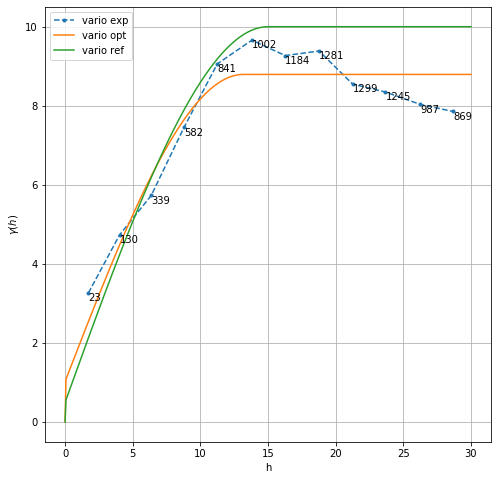

Covariance model 1D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 2.4050831338550465e-07,  r = 3.945677948973101
   Elementary contribution 1: type : spherical
      parameters:  w = 7.7648459939407,  r = 13.166261837269582
   Elementary contribution 2: type : exponential
      parameters:  w = 0.00012584975852085586,  r = 0.5537057892602044
   Elementary contribution 3: type : nugget
      parameters:  w = 1.0271829171150726

In [18]:
cov_model_to_optimize = gcm.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
         ], name='')

cov_model_opt, popt = gcm.covModel1D_fit(x, v, cov_model_to_optimize, hmax=30,
                                         bounds=([ 0,   0, 0,  0,  0,  0,  0],  # min value for param. to fit
                                                 [20, 30, 20, 30, 30, 30, 20]), # max value for param. to fit
                                         make_plot=False)
plt.figure(figsize=(8,8))
gcm.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=30, label='vario opt') # cov. model in 1D
cov_model_ref.plot_model_one_curve(vario=True, hmax=30, label='vario ref') # cov. model in 2D
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error (based on ordinary kriging)
The function `cross_valid_loo_ok` makes a cross-validation test by leave-one-out (LOO) error. 

For a given a data set (in 3D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

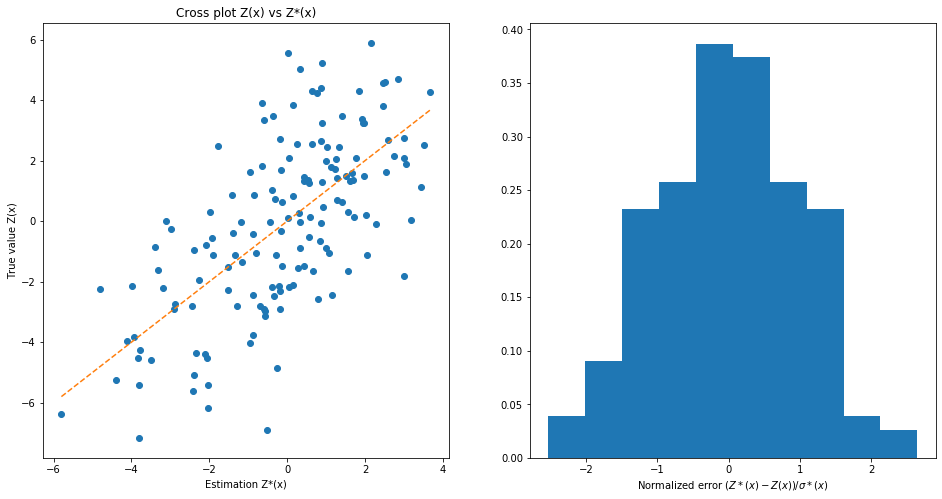

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [19]:
test_passed = gcm.cross_valid_loo_ok(x, v, cov_model_opt, make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(*test_passed))

### Data interpolation by ordinary kriging
The function `ordinary_kriging(x, v, xu, cov_model)` returns the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`.

For a given a data set (in 3D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

For data in 3D:
- `x`: 2-dimensional array of shape `(n, 3)`, location of data points (each row is a point),
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 3)` location of points where the interpolation is done. 

In return:
- `vu`: 1-dimensional array of length `m`, (ordinary) kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, (ordinary) kriging standard deviation at location `xu`.

In [20]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*dz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array of shape nx*ny*nz x 3

# Ordinary kriging
vu, vu_std = gcm.ordinary_kriging(x, v, xu, cov_model_opt)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: ordinary kriging estimates
#   variable 1: ordinary kriging standard deviation
im_ok = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

# Set data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_ok.vmin()[0] # min value in ordinary kriging estimates
cmax = im_ok.vmax()[0] # max value in ordinary kriging estimates
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

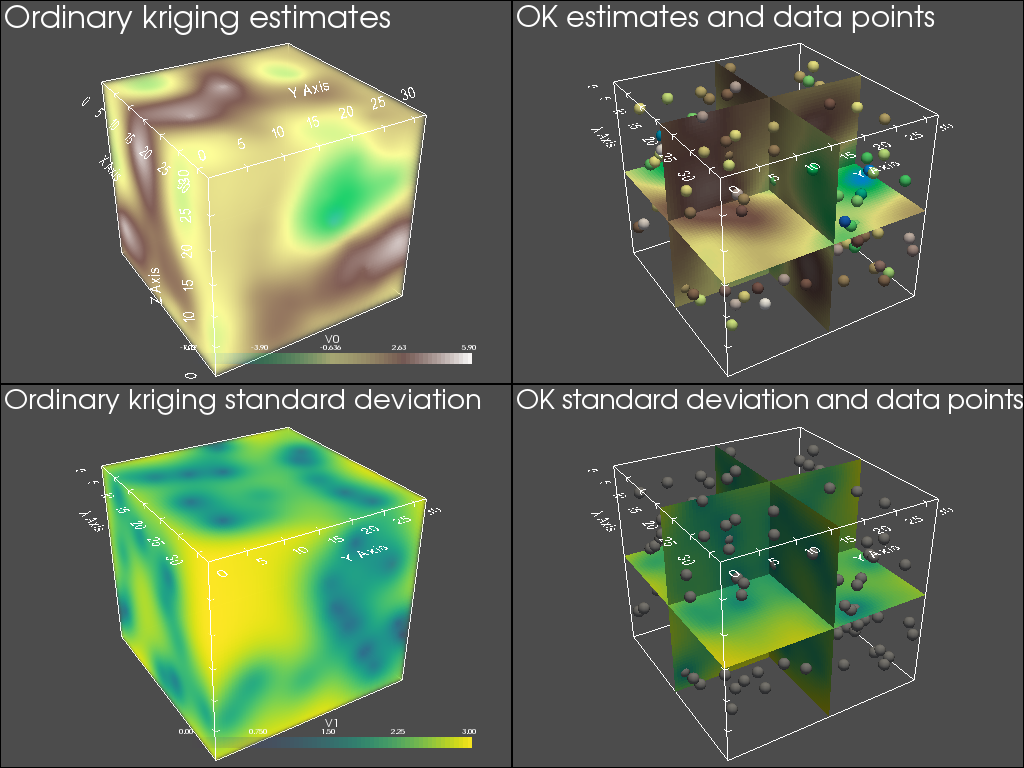

In [21]:
# Plot ordinary kriging estimates and standard deviation
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ok, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ok, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='OK estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_ok, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging standard deviation') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_ok, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='OK standard deviation and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [22]:
# Plot ordinary kriging estimates and standard deviation in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ok, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ok, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='OK estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_ok, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging standard deviation') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_ok, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='OK standard deviation and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(60.580247278154545, -72.16493680469826, 52.20507376337782),
 (16.25, 16.0, 15.0),
 (0.11759931592402381, 0.4357063879939282, 0.8923734332416481)]

### Simple kriging (comparison)
Assuming the data (variable) stationary and specifying a constant mean (computed on the data set), the function `krige3D` (from `geone.grf` module, see jupyter notebook `ex_grf_3d`) can be used to compute simple krging estimates and standard deviation.

As the function `krige3D` requires a covariance model in 3D (class `covModel3D`), the omni-directional covariance model considered (model in 1D) must be converted first.

**Note:** a varying mean can also be specified.

In [23]:
cov_model_opt3D = gcm.covModel1D_to_covModel3D(cov_model_opt) # convert model 1D in 3D
vu_sk, vu_sk_std = grf.krige3D(x, v, cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), 
                               mean=np.mean(v), printInfo=False)

# Fill image (Img class from geone.img) for view
#   variable 0: simple kriging estimates
#   variable 1: simple kriging standard deviation
im_sk = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu_sk, vu_sk_std)))

# Set data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_sk.vmin()[0] # min value in simple kriging estimates
cmax = im_sk.vmax()[0] # max value in simple kriging estimates
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

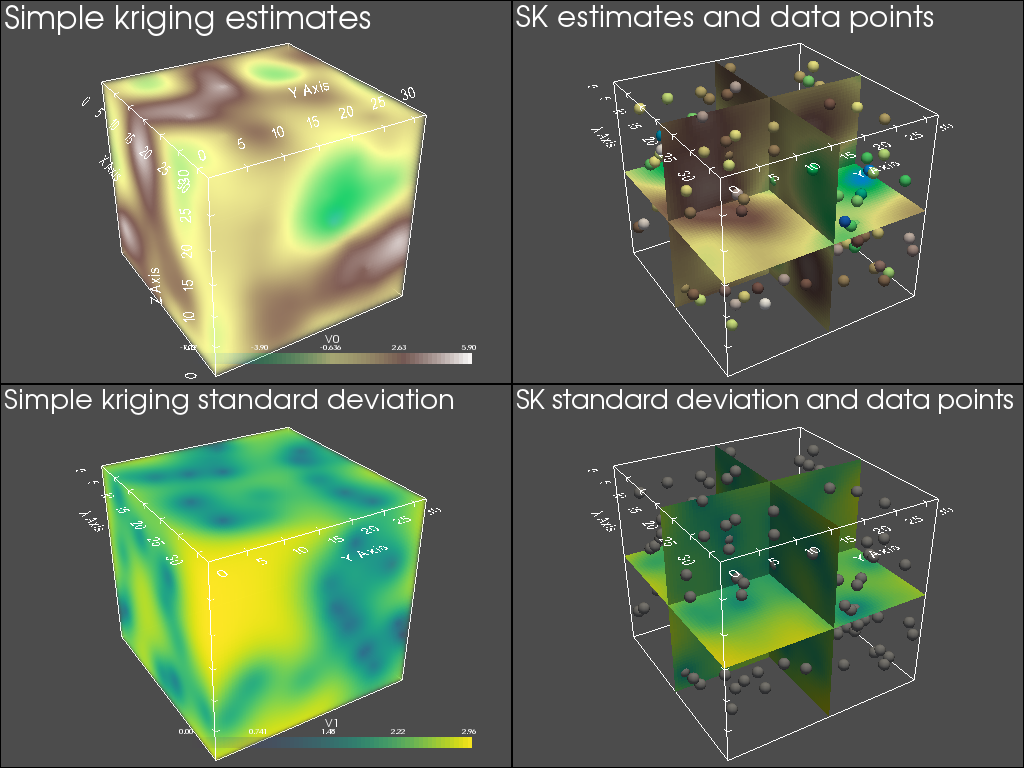

In [24]:
# Plot simple kriging estimates and standard deviation
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_sk, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_sk, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='SK estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_sk, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging standard deviation') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_sk, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='SK standard deviation and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [25]:
# Plot simple kriging estimates and standard deviation in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_sk, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_sk, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='SK estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_sk, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging standard deviation') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_sk, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='SK standard deviation and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(25.640508748479675, -68.54255228494823, 77.3443631601821),
 (16.25, 16.0, 15.0),
 (-0.046659754155772344, 0.5894978848333177, 0.8064211747710793)]

In [26]:
# Difference of simple kriging - ordinary kriging
im_diff = img.copyImg(im_sk)
im_diff.val = im_sk.val - im_ok.val

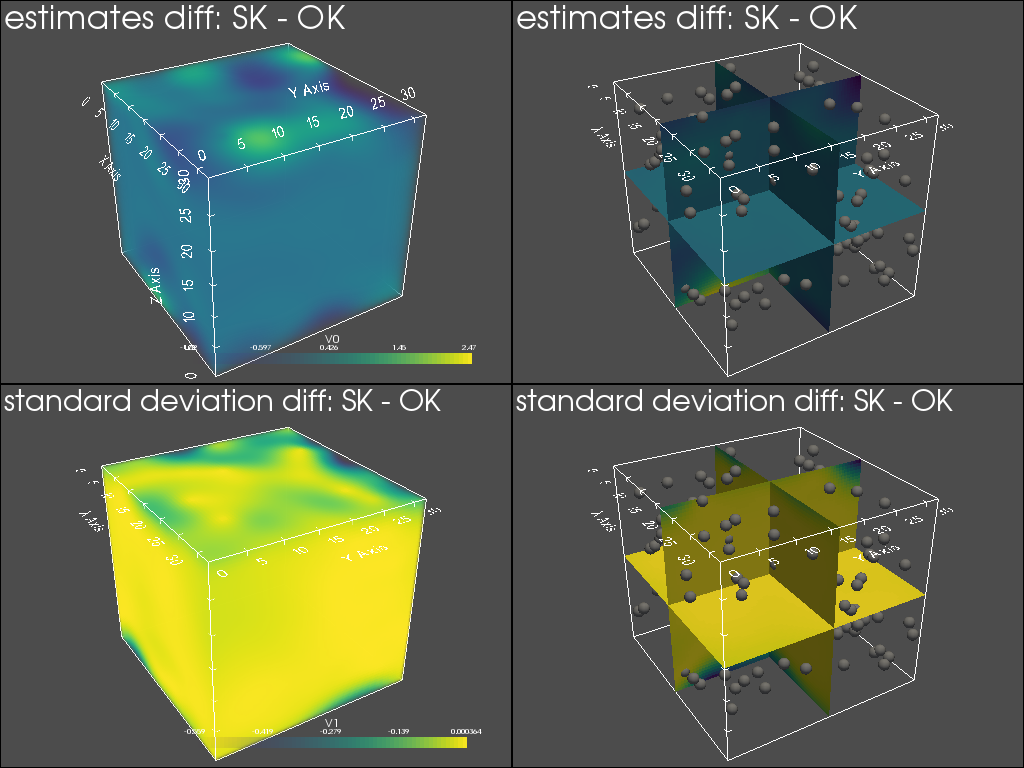

In [27]:
# Plot
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_diff, iv=0, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='estimates diff: SK - OK') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_diff, iv=0, plotter=pp,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='estimates diff: SK - OK') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_diff, iv=1, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='standard deviation diff: SK - OK') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_diff, iv=1, plotter=pp,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='standard deviation diff: SK - OK') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [28]:
# Plot in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_diff, iv=0, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='estimates diff: SK - OK') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_diff, iv=0, plotter=pp,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='estimates diff: SK - OK') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_diff, iv=1, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='standard deviation diff: SK - OK') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_diff, iv=1, plotter=pp,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='standard deviation diff: SK - OK') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(25.81019397300194, -52.25002780527347, 94.83095148521728),
 (16.25, 16.0, 15.0),
 (-0.04925335386410055, 0.756242879772365, 0.6524345284599352)]

### Conditional simulation using the function `grf3D`
Specifying the same mean, the function `grf3D` (from `geone.grf` module, see jupyter notebook `ex_grf_3d`) can be used to generate conditional realizations (based on simple kriging).

In [29]:
# Simulation
np.random.seed(293)
nreal = 3
sim = grf.grf3D(cov_model_opt3D, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), 
                x=x, v=v, nreal=nreal, printInfo=False) # 4d-array of shape nreal x nz x ny x nx

# Fill image (Img class from geone.img) for view
im_sim = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=nreal, val=sim)

im_vmin = min(np.min(im_sim.vmin()), im_ref.vmin()[0]) # min over all real and ref. sim
im_vmax = max(np.max(im_sim.vmax()), im_ref.vmax()[0]) # max over all real and ref. sim


# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_vmin
cmax = im_vmax
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

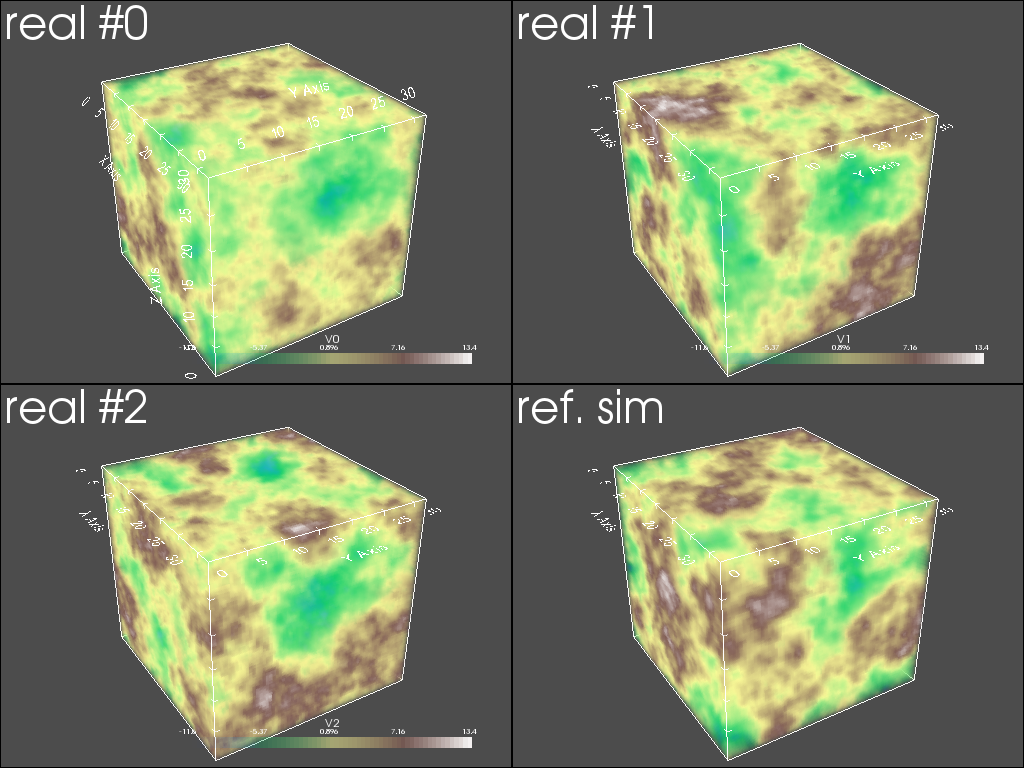

In [30]:
# Plot (volume)
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
i = 0 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title

pp.subplot(0, 1)
i = 1 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title
pp.subplot(1, 0)
i = 2 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title

pp.subplot(1, 1)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='ref. sim') # title

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [31]:
# Plot (volume) in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
i = 0 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title

pp.subplot(0, 1)
i = 1 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title
pp.subplot(1, 0)
i = 2 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title

pp.subplot(1, 1)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='ref. sim') # title

pp.link_views()
pp.show()

[(21.65696506753219, -64.96005010601777, 82.36972194425884),
 (16.25, 16.0, 15.0),
 (-0.005066810210368346, 0.6394326216567818, 0.7688304428126057)]

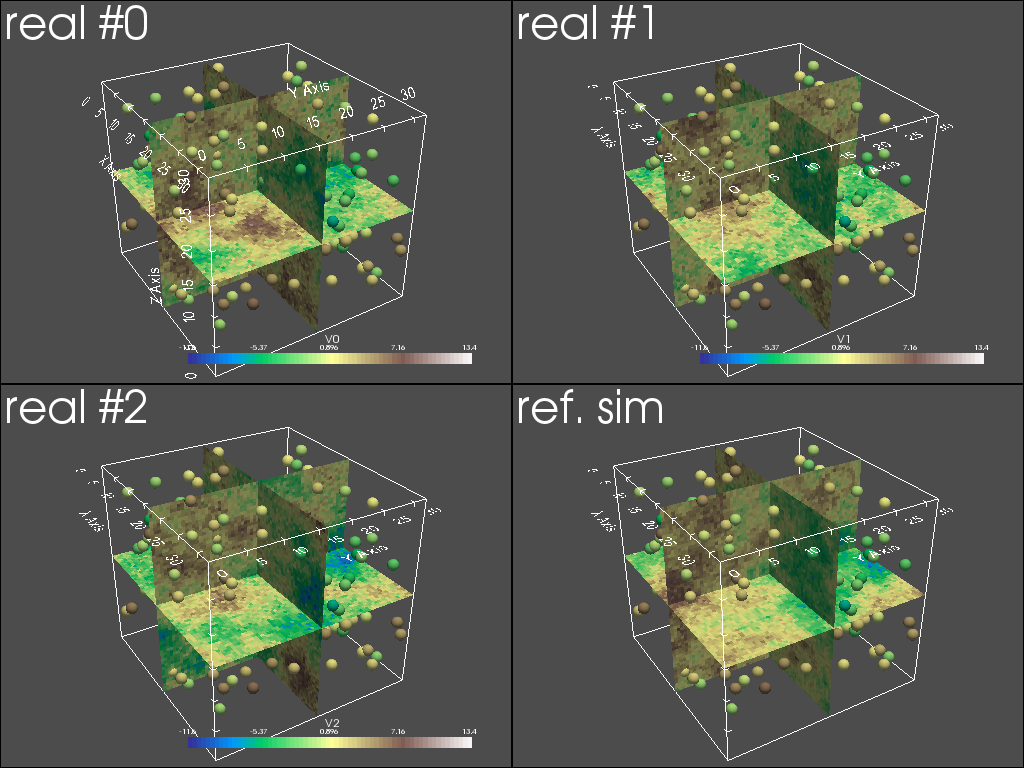

In [32]:
# Plot (slices in 3D block)
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
i = 0 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(0, 1)
i = 1 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
i = 2 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='ref. sim') # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [33]:
# Plot (slices in 3D block) in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
i = 0 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(0, 1)
i = 1 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
i = 2 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='ref. sim') # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(37.55968682925638, -72.22129311553009, 68.7154084739184),
 (16.25, 16.0, 15.0),
 (-0.14243216865410488, 0.4894279686470404, 0.860333273120667)]